# Example workflow in dockerHDDM

Author: 

- Wanke Pan (panwanke2023@gmail.com) @Nanjing Normal University
- Hu Chuan-Peng (corresponding author, hcp4715@hotmail.com) @Nanjing Normal University
- Ru-Yuan Zhang (corresponding author, ruyuanzhang@sjtu.edu.cn) @Shanghai Jiao Tong University

This is a supplementary notebook for the introductary paper *A Hitchhiker’s Guide to Bayesian Hierarchical Drift-Diffusion Modeling with dockerHDDM*. 

This notebook was tested in docker image [`hcp4715/hddm:0.9.8-amd64`](https://hub.docker.com/r/hcp4715/hddm/tags), where the packages `kabuki` were rectfied to RC version as below code box.

Preprint of this manuscript: https://psyarxiv.com/6uzga/

Github repository at: https://github.com/hcp4715/dockerHDDM

## Loading modules/packages

In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC3
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## Load the example data Cavanaght et al. (2011)

The data file is included in HDDM, so we directly load it.

In [2]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data_cavanagh.tail()

subj_idx stim     rt  response     theta  dbs conf
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

In [3]:
print("The number of trials: ", data_cavanagh.shape[0])
print("The number of variables: ", data_cavanagh.shape[1])
print("The number of participants: ", data_cavanagh.subj_idx.unique().shape[0])

The number of trials:  3988
The number of variables:  7
The number of participants:  14


## Model specification and fitting

We define 3 models as below table (Table 2 in main text) from the simplest DDM to full DDM to regression models. Explanation for these three models can be found in **Section "Data and Example Models"** in the main text. 

| Models | HDDM functions for defining a model (`df` is the data from Cavanagh et al., 2011) | # param |
|-|-|-|  
| m0 | hddm.HDDM(df, include=\'a', 'v', 't', *'z', 'sv', 'sz', 'st\]) | 67 |
| m1 | hddm.HDDM(df, include=\['a', 'v', 't','z', 'sv', 'st', 'sz'\], **depends\_on={'v': 'conf'}**) | 82 |
| m2 | hddm.HDDMRegressor(df, **"v ~ C(conf, Treatment('LC'))"**, **group\_only\_regressors=False**, keep\_regressor\_trace=True, include=\['a', 'v', 't', 'z', 'sv', 'st', 'sz'\]) | 83 |

In [4]:
df = data_cavanagh.copy()

# Model 0: base model: full model
m0 = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz', 'st'])

# Model 1: treat within-subj as between-subj: full model
m1 = hddm.HDDM(df, include=['a', 'v', 't','z', 'sv', 'st', 'sz'], depends_on={'v': 'conf'})

# Model 2: regression model (varying intercept and slope)
m2 = hddm.HDDMRegressor(
  df, "v ~ 1 + C(conf, Treatment('LC'))", 
  include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'], 
  group_only_regressors=False, 
  keep_regressor_trace=True)

No model attribute --> setting up standard HDDM
Set model to full_ddm


No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm


Fitting model with new features (parallel sampling and return inferenceData, see [dockerHDDM Quick View](./dockerHDDM_Quick_View.ipynb) and **Section New features in dockerHDDM**). 

We set up 4 MCMC chains with 10,000 samples with 5,000 burn-ins with parallel fitting process and return inferred data for by the code `model.sample(10000, burn = 5000, return_infdata = True)`.

In [5]:
def run_sampling(
    m,
    n_samples=10000,
    n_burn=5000,
    n_chains=4,
    model_name="m",
    progress_bar=True,
):
    """
    Run Markov Chain Monte Carlo (MCMC) sampling for a given model and parameters.
    This function takes a model parameter `m` and runs MCMC sampling using PyMC2.3.8.
    It returns a arviz InferenceData object containing the posterior samples and post-fit model.
    Parameters
    ----------
    m : object
        The model parameter to be sampled.
    n_samples : int, optional
        The number of posterior samples to generate. Default is 10000.
    n_burn : int, optional
        The number of initial samples to discard. Default is 5000.
    n_chains : int, optional
        The number of MCMC chains to run in parallel. Default is 4.
    model_name : str, optional
        The name of the model to be used in the sampling process. Default is "m".
    progress_bar : boolean, optional
        Default=True. Set False hide sampling progress bar. 
    Returns
    -------
    InferenceData : arviz.InferenceData
        A trace object containing the posterior samples.
    Model: HDDM
        A post-fit HDDM model. 
    """

    m_infdata = m.sample(n_samples,
                         burn=n_burn,
                         chains=n_chains,
                         return_infdata=True,
                         save_name="model_fitted/" + model_name,
                         progress_bar=progress_bar)

    return m, m_infdata

**Note: Fitting all these six model with settings above (10000 samples) takes about 8-9 hours on a PC with Intel® Core™ i7-10700 CPU @ 2.90GHz. Also, the memory of should be large enough, ~ 64 G memory is recommended. Otherwise,  recommend few samples**

In [6]:
%%time
m0, m0_infdata = run_sampling(m0, model_name="m0")

[                  0%                  ] 2 of 10000 complete in 1.4 sec
[                  0%                  ] 3 of 10000 complete in 2.3 sec
[                  0%                  ] 5 of 10000 complete in 2.8 sec
[                  0%                  ] 6 of 10000 complete in 3.6 sec
[                  0%                  ] 7 of 10000 complete in 4.2 sec
[                  0%                  ] 8 of 10000 complete in 4.9 sec
[                  0%                  ] 9 of 10000 complete in 5.6 sec
[                  0%                  ] 10 of 10000 complete in 6.4 sec
[                  0%                  ] 11 of 10000 complete in 7.2 sec
[                  0%                  ] 12 of 10000 complete in 7.9 sec
[                  0%                  ] 13 of 10000 complete in 8.8 sec
[                  0%                  ] 14 of 10000 complete in 9.5 sec
[                  0%                  ] 15 of 10000 complete in 10.2 sec
[                  0%                  ] 16 of 10000 comp

In [7]:
%%time
# Set progress_bar=False to hide the program's progress bar to simplify the output
m1, m1_infdata = run_sampling(m1, model_name="m1", progress_bar=False)

hddm sampling elpased time:  6735.545 s
Start converting to InferenceData...
CPU times: user 8.19 s, sys: 135 ms, total: 8.32 s
Wall time: 1h 52min 16s


In [9]:
%%time
# Set progress_bar=False to hide the program's progress bar to simplify the output
m2, m2_infdata = run_sampling(m2, model_name="m2", progress_bar=False)

hddm sampling elpased time:  11139.892 s
Start converting to InferenceData...
CPU times: user 23.2 s, sys: 794 ms, total: 24 s
Wall time: 3h 5min 41s


## Model diagnosis

We use `az.plot_trace()` to visually check the trace plot of MCMC chains and use `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS). 

### Diagnosis of Model 0

#### Trace plot

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

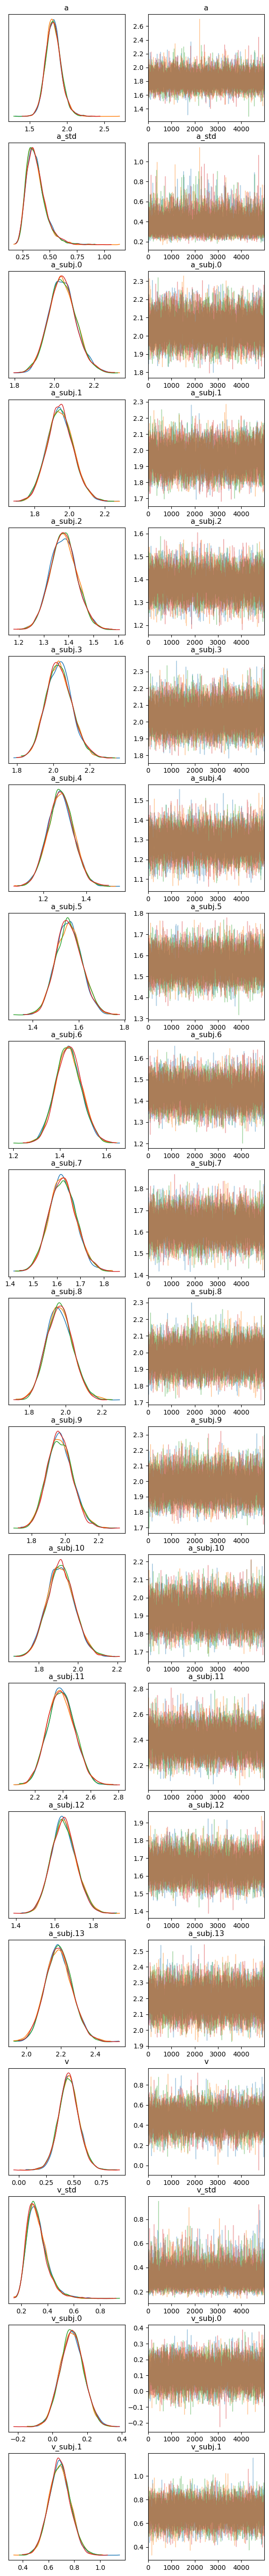

In [10]:
tmp_infdata = m0_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [7, 70])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


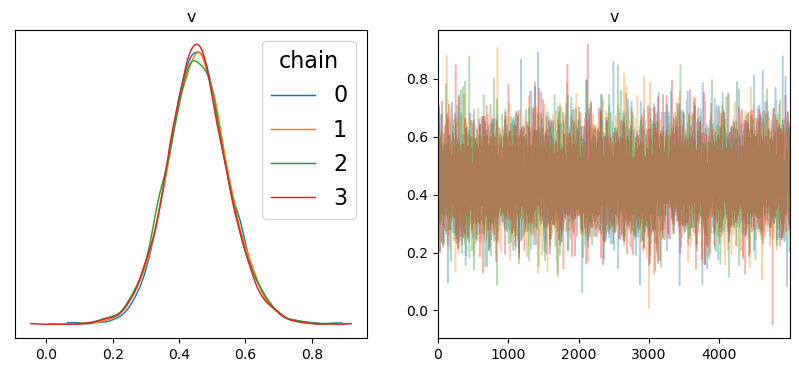

In [50]:
# select population level parameter v as a example
axes = az.plot_trace(
    tmp_infdata, 
    var_names= ('v'), 
    compact = False, 
    legend=True, 
    figsize = [10, 4]
)

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


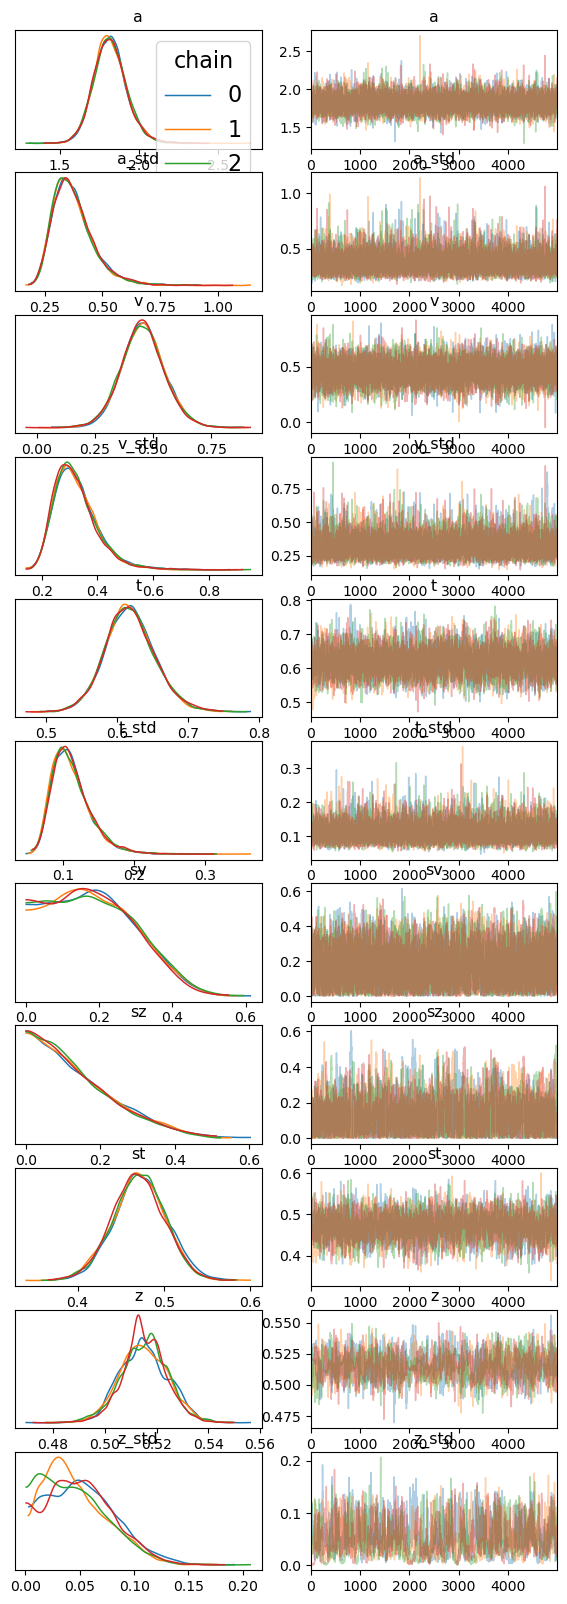

In [12]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [7, 20]
)

#### $\hat{R}$ and ESS

In [13]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
z_std         0.0013   0.0009   425.5902   451.8641  1.0132
z_subj.10     0.0006   0.0004   718.8918  1516.5931  1.0068
z             0.0004   0.0002   658.0802  1666.0598  1.0052
t_subj.4      0.0005   0.0004  2219.4995  3842.6706  1.0051
z_subj.1      0.0004   0.0003  1137.8897  3817.8410  1.0050
z_subj.11     0.0003   0.0002  1699.4180  5051.1148  1.0045
t_subj.1      0.0008   0.0006  1840.7526  2430.6529  1.0041
z_subj.7      0.0003   0.0002  1814.9990  5060.0522  1.0041
z_subj.13     0.0003   0.0002  1613.6463  4644.7192  1.0039
z_subj.12     0.0004   0.0003  1267.3623  4012.9876  1.0036

In [14]:
# only calculate R hat
az.rhat(tmp_infdata).values

<bound method Mapping.values of <xarray.Dataset> Size: 536B
Dimensions:    ()
Data variables: (12/67)
    a          float64 8B 0.9999
    a_std      float64 8B 1.0
    a_subj.0   float64 8B 1.0
    a_subj.1   float64 8B 1.001
    a_subj.2   float64 8B 1.0
    a_subj.3   float64 8B 1.0
    ...         ...
    z_subj.8   float64 8B 1.003
    z_subj.9   float64 8B 1.003
    z_subj.10  float64 8B 1.007
    z_subj.11  float64 8B 1.004
    z_subj.12  float64 8B 1.004
    z_subj.13  float64 8B 1.004>

In [15]:
# only calculate ESS
az.ess(tmp_infdata).values

<bound method Mapping.values of <xarray.Dataset> Size: 536B
Dimensions:    ()
Data variables: (12/67)
    a          float64 8B 1.146e+04
    a_std      float64 8B 9.267e+03
    a_subj.0   float64 8B 6.142e+03
    a_subj.1   float64 8B 5.001e+03
    a_subj.2   float64 8B 4.876e+03
    a_subj.3   float64 8B 7.017e+03
    ...         ...
    z_subj.8   float64 8B 1.215e+03
    z_subj.9   float64 8B 1.329e+03
    z_subj.10  float64 8B 718.9
    z_subj.11  float64 8B 1.699e+03
    z_subj.12  float64 8B 1.267e+03
    z_subj.13  float64 8B 1.614e+03>

### Diagnosis of Model 1

#### Trace plot

In [51]:
tmp_infdata = m1_infdata

# plot traces for all parameters
# axes = az.plot_trace(tmp_infdata, compact = False, figsize = [7, 70])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


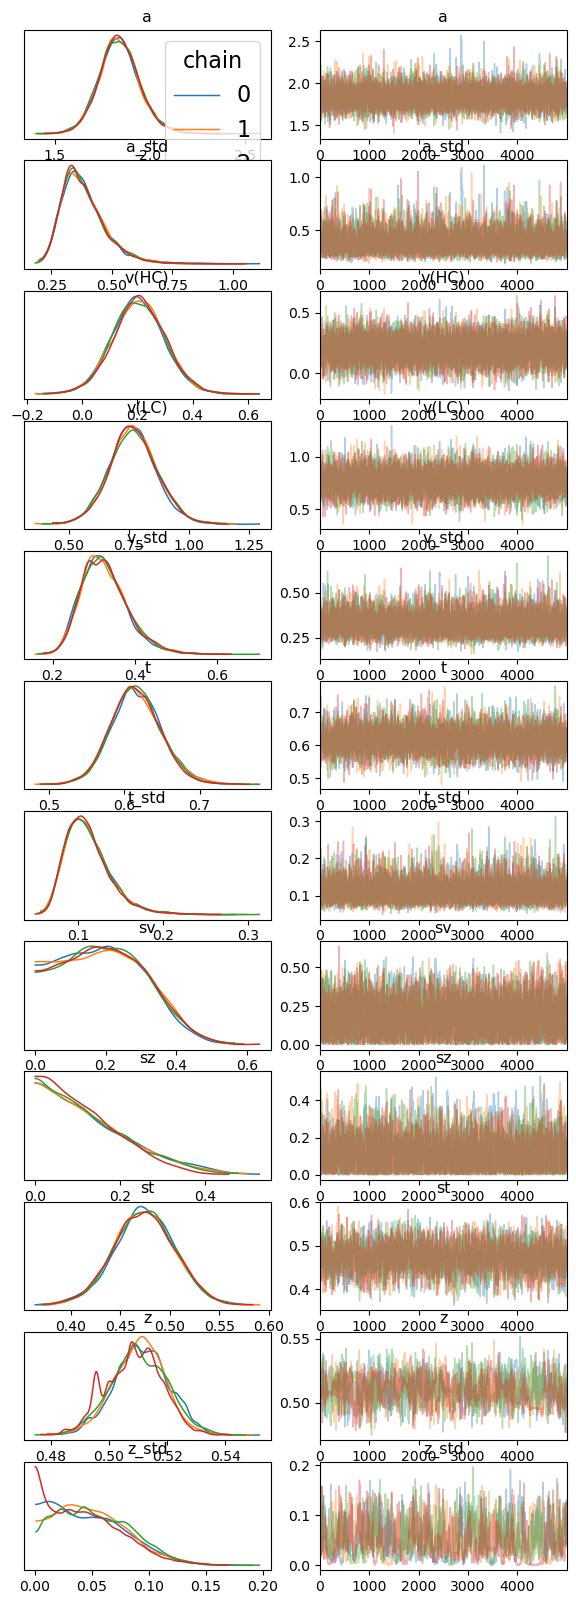

In [17]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [7, 20]
)

#### $\hat{R}$ and ESS

In [18]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
z_std         0.0017   0.0012   293.8166   239.3520  1.0156
z_subj.10     0.0008   0.0006   503.5108   239.7519  1.0155
z             0.0004   0.0003   470.3783  1122.2618  1.0141
z_subj.8      0.0005   0.0003   852.3467  3019.4751  1.0114
z_subj.4      0.0005   0.0003   933.7400  3623.0933  1.0100
z_subj.1      0.0005   0.0004   795.9172  2886.2517  1.0095
z_subj.13     0.0004   0.0003   956.5060  3530.1094  1.0093
z_subj.12     0.0005   0.0004   844.1818  2766.6764  1.0091
z_subj.2      0.0005   0.0003   949.2420  3695.4760  1.0083
z_subj.3      0.0004   0.0003  1032.1055  4940.5928  1.0063

### Diagnosis of Model 2

#### Trace plot

In [21]:
tmp_infdata = m2_infdata

# plot traces for all parameters
# axes = az.plot_trace(tmp_infdata, compact = False, figsize = [7, 70])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


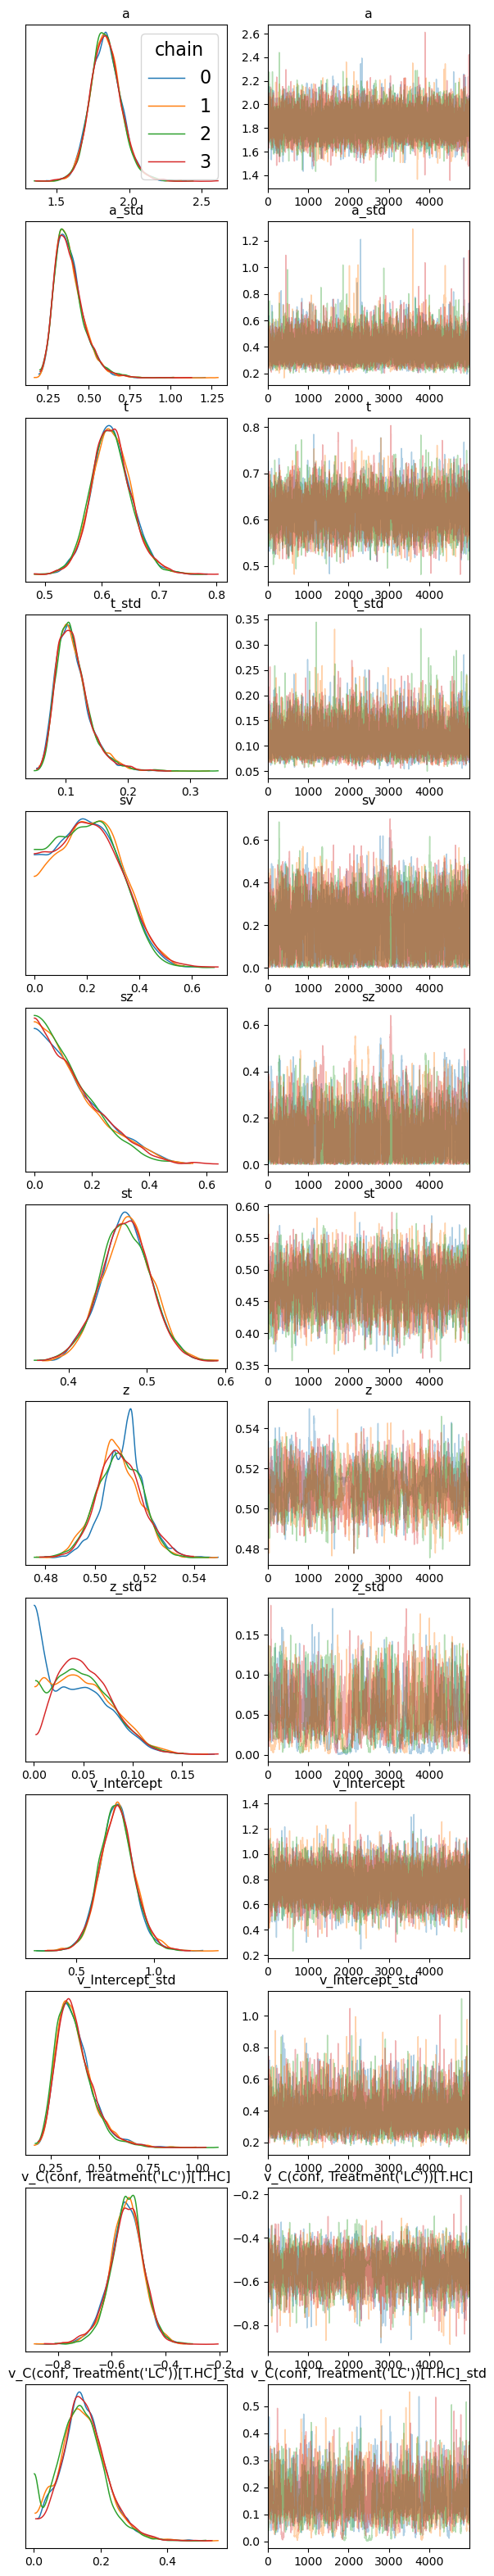

In [22]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [7, 40]
)

#### $\hat{R}$ and ESS

In [23]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   
z_std                                    0.0017   0.0012   223.5641  \
z                                        0.0003   0.0002   794.9641   
z_subj.5                                 0.0005   0.0003  1087.1673   
z_subj.9                                 0.0004   0.0003  1198.3803   
z_subj.6                                 0.0004   0.0003  1328.7416   
z_subj.8                                 0.0004   0.0003  1491.8643   
z_subj.2                                 0.0004   0.0002  1584.2258   
v_C(conf, Treatment('LC'))[T.HC]_std     0.0024   0.0017   714.8018   
z_subj.12                                0.0004   0.0003  1292.8690   
z_subj.11                                0.0003   0.0002  1797.9384   

                                       ess_tail   r_hat  
z_std                                  186.9666  1.0181  
z                                     1560.2810  1.0095  
z_subj.5                              4161.4777  1.0089  
z_subj.9                              3666.7282  1.0074  
z_subj.6                              4275.4789  1.0068  
z_subj.8                              4741.7229  1.0065  
z_subj.2                              4922.9620  1.0064  
v_C(conf, Treatment('LC'))[T.HC]_std   450.5181  1.0059  
z_subj.12                             4943.5490  1.0055  
z_subj.11                             4862.5218  1.0054

#### non-converge example

Since `z_std` have $\hat{R}$ > 1.01 and ESS bulk < 400, we double-check these two parameters with a trace plot.

- In terms of the posterior distribution, 'z_std' differ in the consistency of convergence of the four chains and their hdi (highest density interval).
- Since the 'z_std' obeys the truncate distribution, its mean and mode are clustered around 0
- However, from the trace plot, it is clear that 'z_std' has non-converge feature in chain 2 (the long regions of monotonicity like a line parallel to the x-axis).
    - (see 2.4 Diagnosing Numerical Inference in Martin, O.A., et. cl (2021) Bayseian Modeling and Computation in Python).

However, in general, the $\hat{R}$ of the two parameters is close to 1.01, and more broadly speaking, less than 1.1. And the distribution of the chains is still stable and consistent, we think this result is acceptable.

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


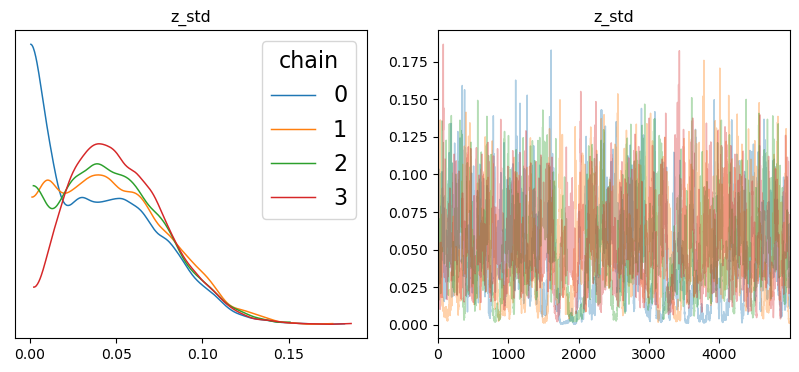

In [42]:
# select `z_std`
axes = az.plot_trace(
    m2_infdata, 
    var_names=['z_std'], 
    compact = False, 
    legend=True, 
    figsize = [10, 4]
)

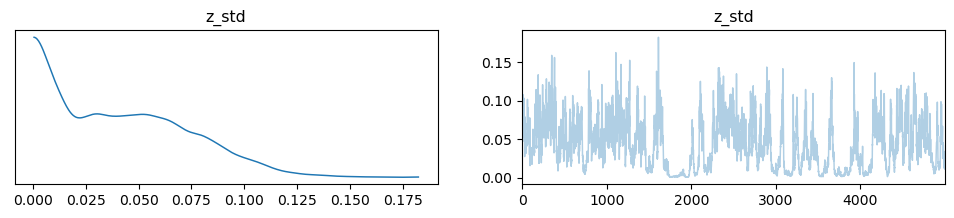

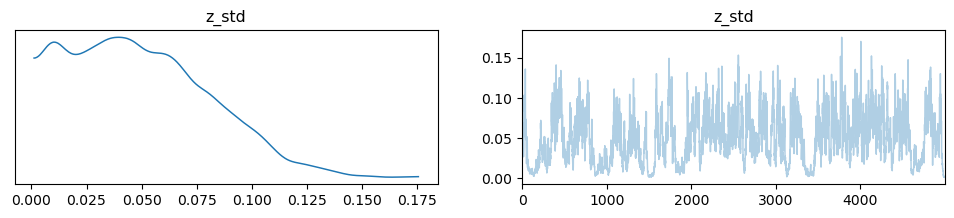

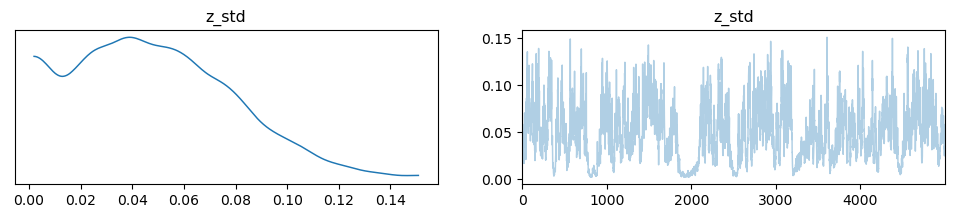

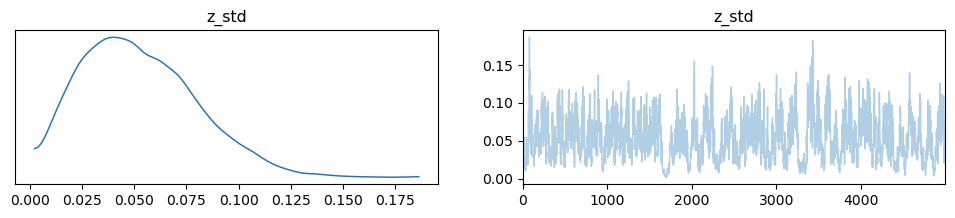

In [27]:
for i in range(4):
    
    az.plot_trace(
        m2_infdata, 
        var_names=['z_std'], 
        coords = {'chain': [i]}, 
        compact = False, 
        combined = False
    )

## Model comparison and selection

### DIC

Here we retrieve the DIC from each model in the models and sort by DIC.

In [ ]:
dic_dict = {
  "m0(baseline)":m0.dic,
  "m1(v depends on conf)":m1.dic,
  "m2(reg: v ~ 1 + conf)":m2.dic
}

comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic.sort_values(by=['DIC'], ascending = True)

model           DIC
m2    m2  10654.862529
m1    m1  10655.267937
m0    m0  10835.366914

### PSIS-LOO-CV

To evaluate models with criterions like WAIC and PSIS-LOO-CV, pointwise loglikelihoods are required (see Section Model Comparison in Manuscript). 

The following code shows how to calculate the pointwise loglikelihoods (note that it may take a few hours).

In [29]:
%%time
m0_infdata = m0.to_infdata(loglike = True, save_name = "model_fitted/m0")

Start to calculate pointwise log likelihood...
[-----------------100%-----------------] 10001 of 10000 complete in 11003.8 sec
hddm sampling elpased time:  11005.972 s
[-----------------99%----------------- ] 9991 of 10000 complete in 11113.2 sec
[-----------------99%----------------- ] 9992 of 10000 complete in 11114.3 sec
[-----------------99%----------------- ] 9993 of 10000 complete in 11115.5 sec
[-----------------99%----------------- ] 9994 of 10000 complete in 11116.5 sec
[-----------------99%----------------- ] 9995 of 10000 complete in 11117.6 sec
[-----------------99%----------------- ] 9996 of 10000 complete in 11118.5 sec
[-----------------99%----------------- ] 9997 of 10000 complete in 11119.5 sec
[-----------------99%----------------- ] 9998 of 10000 complete in 11120.5 sec
[-----------------99%----------------- ] 9999 of 10000 complete in 11121.4 sec
[-----------------100%-----------------] 10000 of 10000 complete in 11122.5 sec
[-----------------100%-----------------] 

In [30]:
%%time
m1_infdata = m1.to_infdata(loglike = True, save_name = "model_fitted/m1")

Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 115.769 seconds
Start converting to InferenceData...
CPU times: user 1min 35s, sys: 6.2 s, total: 1min 41s
Wall time: 2min 37s


In [31]:
%%time
m2_infdata = m2.to_infdata(loglike = True, save_name = "model_fitted/m2")

Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 1402.580 seconds
Start converting to InferenceData...
CPU times: user 1min 40s, sys: 6.36 s, total: 1min 47s
Wall time: 24min 9s


Warining here is caused by large number as input of `exp()`, solution is [here](https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function).

In [32]:
compare_dict = {
  "m0":m0_infdata,
  "m1":m1_infdata,
  "m2":m2_infdata
}

####  WAIC

In [34]:
comp_waic = az.compare(compare_dict, ic='waic', scale="deviance")
comp_waic

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:256: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_full)


rank     elpd_waic       p_waic    elpd_diff    weight           se   
m1     0  24646.549487  6923.830078     0.000000  0.333333  7141.400609  \
m2     1  24683.121824  6937.783845    36.572336  0.333333  7292.176469   
m0     2  26076.361080  7537.594727  1429.811593  0.333333  7580.282609   

           dse  warning     scale  
m1    0.000000     True  deviance  
m2  710.980231     True  deviance  
m0  777.451108     True  deviance

#### PSIS-LOO-CV

In [33]:
comp_loo = az.compare(compare_dict, ic='loo', scale="deviance")
comp_loo

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: inv

rank      elpd_loo        p_loo  elpd_diff    weight           se  dse   
m2     0  15897.784567  2545.115217        0.0  0.333333  2287.481373  0.0  \
m0     1           NaN          NaN        NaN  0.333333          NaN  NaN   
m1     2           NaN          NaN        NaN  0.333333          NaN  NaN   

    warning     scale  
m2     True  deviance  
m0     True  deviance  
m1     True  deviance

### PSIS issues

**Warnings**: The above result shows that m0 and m1 are unable to compute PSIS-LOO-CV(elpd_loo), this is because of the overflow encountered in some calculation as the above warnings. 

As follow, we can check pareto_k $\hat{k}$. If $\hat{k} >  0.7$, which means importance sampling (PSIS) is not able to provide useful estimate for that component/observation. Highly influential observations have high $\hat{k}$ values. Very high $\hat{k}$ values often indicate model misspecification, outliers or mistakes in data processing.

Also, `p_loo`is large than *p*, which is number of parameters of the model. Large `p_loo` means the model is badly misspecified according to Aki Vehtari's [Q & A](https://avehtari.github.io/modelselection/CV-FAQ.html#18_What_is_the_interpretation_of_p_loo). For all models, the *N*, number of obersvations, is 3988, and the number of parameters varies from 48 to 83. Thus, `p_loo` is much larger than numbers of parameters for all models.

As we can from below, this was primarily because of a few outliers. As HDDM allow for 5 percent of outliers in modelling, it is not surprising that these outliers stronly influenced the model performance. Here, we remove the outliers from all models and check the results again.

Below we visulaize the `k_hat` of each data point.

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post


CPU times: user 10.2 s, sys: 23 ms, total: 10.2 s
Wall time: 10.2 s


<AxesSubplot: xlabel='Data Point', ylabel='Shape parameter k'>

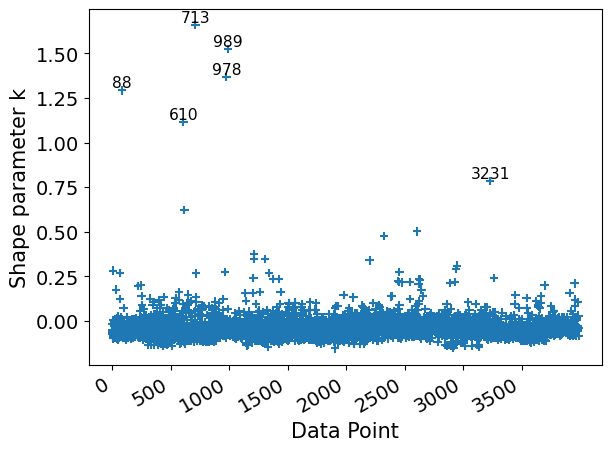

In [53]:
%%time
khats = az.loo(m1_infdata, pointwise=True).pareto_k

az.plot_khat(khats, xlabels=True, threshold=0.7)

Plot pointwise elpd differences between two or more models

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: inv

CPU times: user 59.4 s, sys: 206 ms, total: 59.6 s
Wall time: 59.6 s


<AxesSubplot: title={'center': 'm0 - m1'}, ylabel='ELPD difference'>

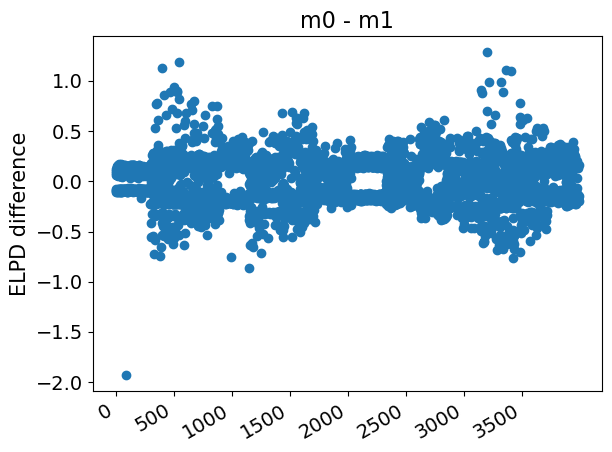

In [52]:
%%time
az.plot_elpd({"m0": m0_infdata, "m1": m1_infdata}, xlabels=True)

Here we used a very simple soluation: removing the outliers and re-calculate the `loo`.

In [54]:
%%time
loo_m0 = az.loo(m0_infdata, pointwise=True)
loo_m1 = az.loo(m1_infdata, pointwise=True)
loo_m2 = az.loo(m2_infdata, pointwise=True)

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: inv

CPU times: user 32.8 s, sys: 5.85 ms, total: 32.8 s
Wall time: 32.8 s


In [55]:
outliers0 = loo_m0.pareto_k.where(loo_m0.pareto_k >= 0.7, drop= True).obs_id.values
outliers1 = loo_m1.pareto_k.where(loo_m1.pareto_k >= 0.7, drop= True).obs_id.values
outliers2 = loo_m2.pareto_k.where(loo_m2.pareto_k >= 0.7, drop= True).obs_id.values

# create a index array to remove outliers
outliers = np.unique(np.concatenate((outliers0, outliers1, outliers2), axis=0))
new_indx = data_cavanagh.index.values[~np.isin(data_cavanagh.index.values, outliers)]

In [56]:
%%time
m0_infdata = m0_infdata.isel(obs_id=new_indx)
m1_infdata = m1_infdata.isel(obs_id=new_indx)
m2_infdata = m2_infdata.isel(obs_id=new_indx)

CPU times: user 1min 7s, sys: 839 ms, total: 1min 8s
Wall time: 1min 8s


In [57]:
compare_dict2 = {
  "m0(delete outliers)":m0_infdata,
  "m1(delete outliers)":m1_infdata,
  "m2(delete outliers)":m2_infdata
}

In [59]:
comp_loo2 = az.compare(compare_dict2, ic='loo', scale="deviance")
comp_loo2

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


rank      elpd_loo      p_loo   elpd_diff    weight   
m2(delete outliers)     0  10808.915163  55.260694    0.000000  0.457117  \
m1(delete outliers)     1  10810.492096  60.300720    1.576933  0.466414   
m0(delete outliers)     2  10988.056578  46.225694  179.141414  0.076469   

                             se        dse  warning     scale  
m2(delete outliers)  124.548105   0.000000    False  deviance  
m1(delete outliers)  124.385197   5.824723    False  deviance  
m0(delete outliers)  121.572323  28.273501    False  deviance

## Posterior predictive check

First, let's spend some time generating posterior predictions. Note that we set `n_ppc` is 500 means we generate 500 samples for each draws in each parameters. 

In [63]:
%%time
m0_infdata = m0.to_infdata(loglike = True, ppc = True, n_ppc = 500, save_name = "model_fitted/m0")
m1_infdata = m1.to_infdata(loglike = True, ppc = True, n_ppc = 500, save_name = "model_fitted/m1")
m2_infdata = m2.to_infdata(loglike = True, ppc = True, n_ppc = 500, save_name = "model_fitted/m2")

The time of calculation of loglikelihood took 0.000 seconds
Start generating posterior prediction...
The time of generating PPC took 108.211 seconds
Start converting to InferenceData...
The time of calculation of loglikelihood took 0.000 seconds
Start generating posterior prediction...
The time of generating PPC took 139.313 seconds
Start converting to InferenceData...
The time of calculation of loglikelihood took 0.000 seconds
Start generating posterior prediction...
The time of generating PPC took 122.651 seconds
Start converting to InferenceData...
CPU times: user 6min 35s, sys: 37.4 s, total: 7min 12s
Wall time: 9min 23s


Then, we can plot the ppc by setting different coordinates. 

- Here we demonstrate plotting both the individual leve, `subj_idx` is 3, 11
- and the experimental condition level, `conf` is LC and HC. 

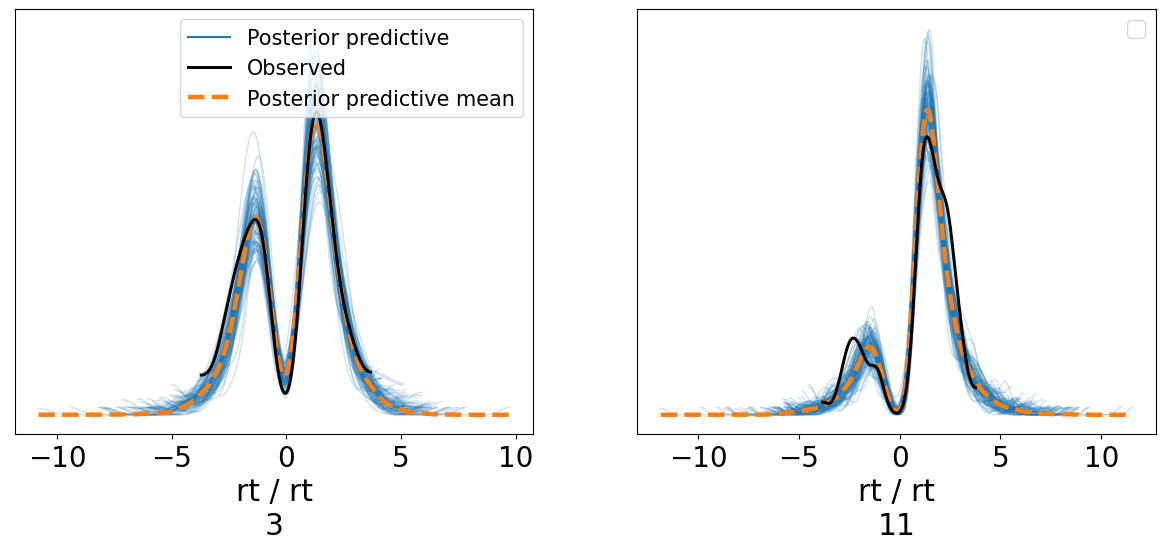

In [64]:
# reset coordinates
m0_infdata = m0_infdata.assign_coords(
  obs_id=m0_infdata.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

# plot ppc for subj_idx (obs_id) is 0,1,2 and 3
axes = az.plot_ppc(
    m0_infdata, 
    var_names= 'rt', 
    coords={'obs_id': [3,11]}, 
    num_pp_samples=100,
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

In [ ]:
# render figure for manuscript
axes.ravel()[0].figure.savefig("fig_ppc_m0_by_subject.pdf")

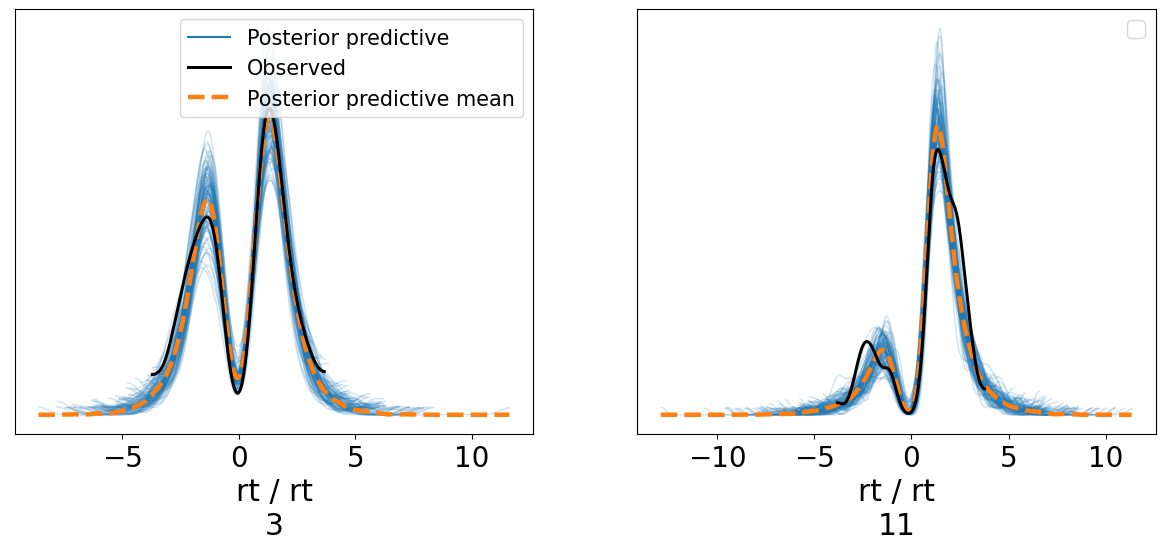

In [65]:
# reset coordinates
m2_infdata = m2_infdata.assign_coords(
  obs_id=m2_infdata.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

# plot ppc for subj_idx (obs_id) is 0,1,2 and 3
axes = az.plot_ppc(
    m2_infdata, 
    var_names= 'rt', 
    coords={'obs_id': [3, 11]}, 
    num_pp_samples=100, 
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

In [ ]:
# render figure for manuscript
axes.ravel()[0].figure.savefig("fig_ppc_m2_by_subject.pdf")

It is found that model 4 generate more similar predictions to observed data, especially for subject 11. 

Then, let us plot ppc on different conditions. 

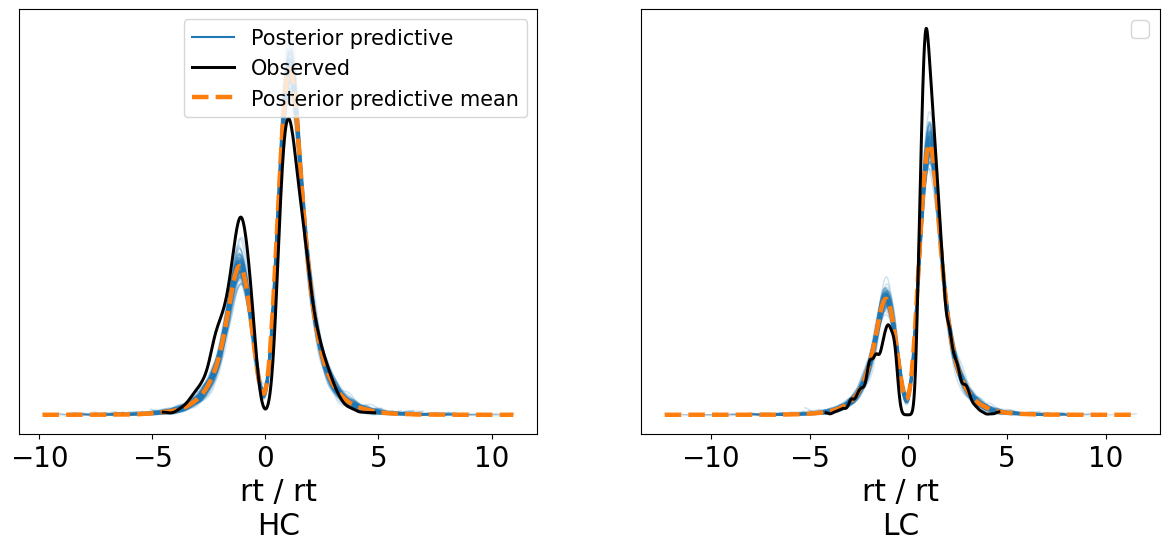

In [66]:
# reset coordinates
m0_infdata = m0_infdata.assign_coords(
  obs_id=m0_infdata.observed_data.variables['conf'].values, 
  groups="observed_vars")


# plot ppc by conditions
axes = az.plot_ppc(
    m0_infdata, 
    var_names= 'rt', 
    coords={'obs_id': ["LC", "HC"]}, 
    num_pp_samples=100, 
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

In [ ]:
# render figure for manuscript
axes.ravel()[0].figure.savefig("fig_ppc_m0_by_condition.pdf")

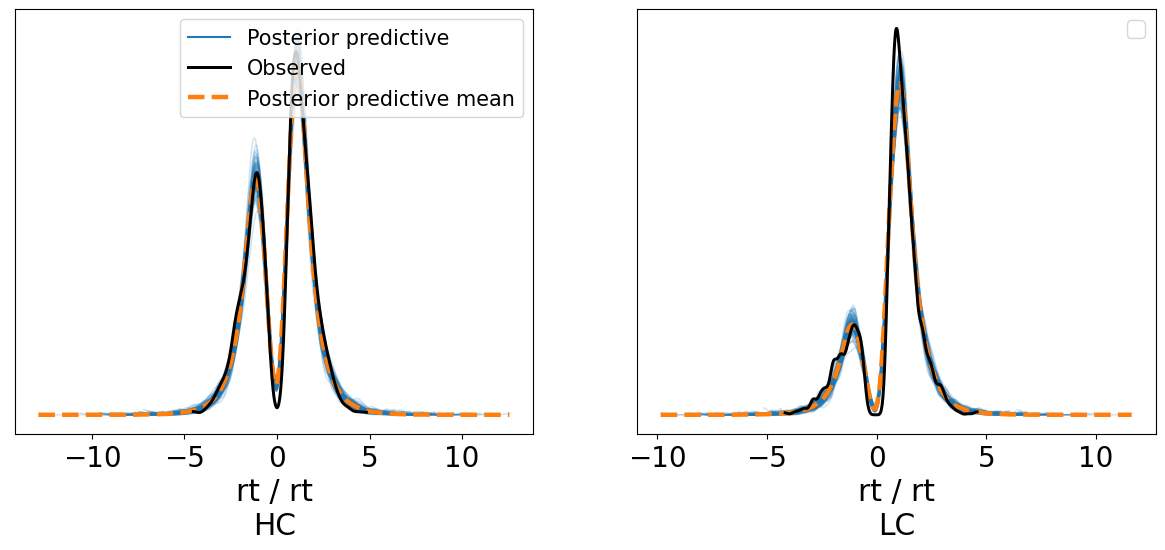

In [67]:
# reset coordinates
m2_infdata = m2_infdata.assign_coords(
  obs_id=m2_infdata.observed_data.variables['conf'].values, 
  groups="observed_vars")


# plot ppc by conditions
axes = az.plot_ppc(
    m2_infdata, 
    var_names= 'rt', 
    coords={'obs_id': ["LC", "HC"]}, 
    num_pp_samples=100, 
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

In [ ]:
# render figure for manuscript
axes.ravel()[0].figure.savefig("fig_ppc_m2_by_condition.pdf")

Model 4 get better predictions for both conflict condition (LC vs. HC), given that model 0 did not consider the impact from conflict condition. 

### Custom PPC plotting function

To make it easier to plot ppc under different conditions, we define a function plot_ppc_by_cond, demonstrated as follows.

In [68]:
# define custom plot function
def plot_ppc_by_cond(infdata,
                     subj_idx=None,
                     condition_vars=None,
                     num_pp_samples=500,
                     **kwargs):
    """Extends arviz's plot_ppc function to allow plotting of ppc for different experimental conditions and subjects.

    Args:
        infdata (InferenceData from Arviz): The output from dockerHDDM sampling. 
        subj_idx (str or list of str, optional): Defaults to None that mean plot all subjects or plot only condition level when `condition_vars` is not None. If `subj_idx` is "all", it plots all subjects vary with condition level.  
        condition_vars (str, list of str or dict, optional): Defaults to None. `condition_vars` can be a str of variable name ('conf') or list of variable names (['conf','stim']). It support selecting condition levels of variable name, such as `{'stim':['WW','LL']}`. 
        num_pp_samples (int, optional): The number of posterior predictives used for plotting. Defaults to 500.
        **kwargs: Other arguments will be sended to `arviz.plot_ppc()`. 

    Returns:
        axes: The matplotlib axes. 
    """

    import arviz as az

    tmp_infdata = infdata.copy()

    if isinstance(subj_idx, list):
        lookup = tmp_infdata.observed_data.subj_idx
        tmp_infdata.observed_data = tmp_infdata.observed_data.where(
            lookup.isin(subj_idx), drop=True)
        tmp_infdata.posterior_predictive = tmp_infdata.posterior_predictive.where(
            lookup.isin(subj_idx), drop=True)
    elif isinstance(subj_idx, str):
        if subj_idx != "all":
            raise ValueError("subj_idx must be 'all' or a list of subject indices")
    else:
        if subj_idx is not None:
            raise ValueError("subj_idx must be 'all' or a list of subject indices")

    if condition_vars is not None:
        if isinstance(condition_vars, str) or isinstance(condition_vars, list):

            condition_vars = [condition_vars] if isinstance(condition_vars, str) else condition_vars
            tmp_df = tmp_infdata.observed_data[condition_vars].to_dataframe(
            ).reset_index()

        elif isinstance(condition_vars, dict):

            tmp_df = tmp_infdata.observed_data[
                condition_vars.keys()].to_dataframe().reset_index()

            for key, value in condition_vars.items():
                tmp_df = tmp_df[tmp_df[key].isin(value)]

                lookup = tmp_infdata.observed_data[key]
                tmp_infdata.observed_data = tmp_infdata.observed_data.where(
                    lookup.isin(value), drop=True)
                tmp_infdata.posterior_predictive = tmp_infdata.posterior_predictive.where(
                    lookup.isin(value), drop=True)

            # compatible for list
            condition_vars = list(condition_vars.keys())

        if subj_idx is None:
            total_vars = condition_vars
        else:
            total_vars = ['subj_idx'] + condition_vars
    else:
        total_vars = ['subj_idx']
        tmp_df = tmp_infdata.observed_data[total_vars].to_dataframe().reset_index()

    format_str = '_'.join(
        [f"{col[:4]}({{{col}}})" for col in tmp_df[total_vars].columns])
    tmp_df['obs_id'] = tmp_df.apply(lambda row: format_str.format(**row), axis=1)

    for_plot_infdata = tmp_infdata.assign_coords(obs_id=tmp_df.obs_id.values,
                                                 groups="observed_vars")

    axes = az.plot_ppc(for_plot_infdata,
                       var_names='rt',
                       coords={'obs_id': list(tmp_df['obs_id'].unique())},
                       flatten=[],
                       num_pp_samples=num_pp_samples,
                       **kwargs)

    return axes


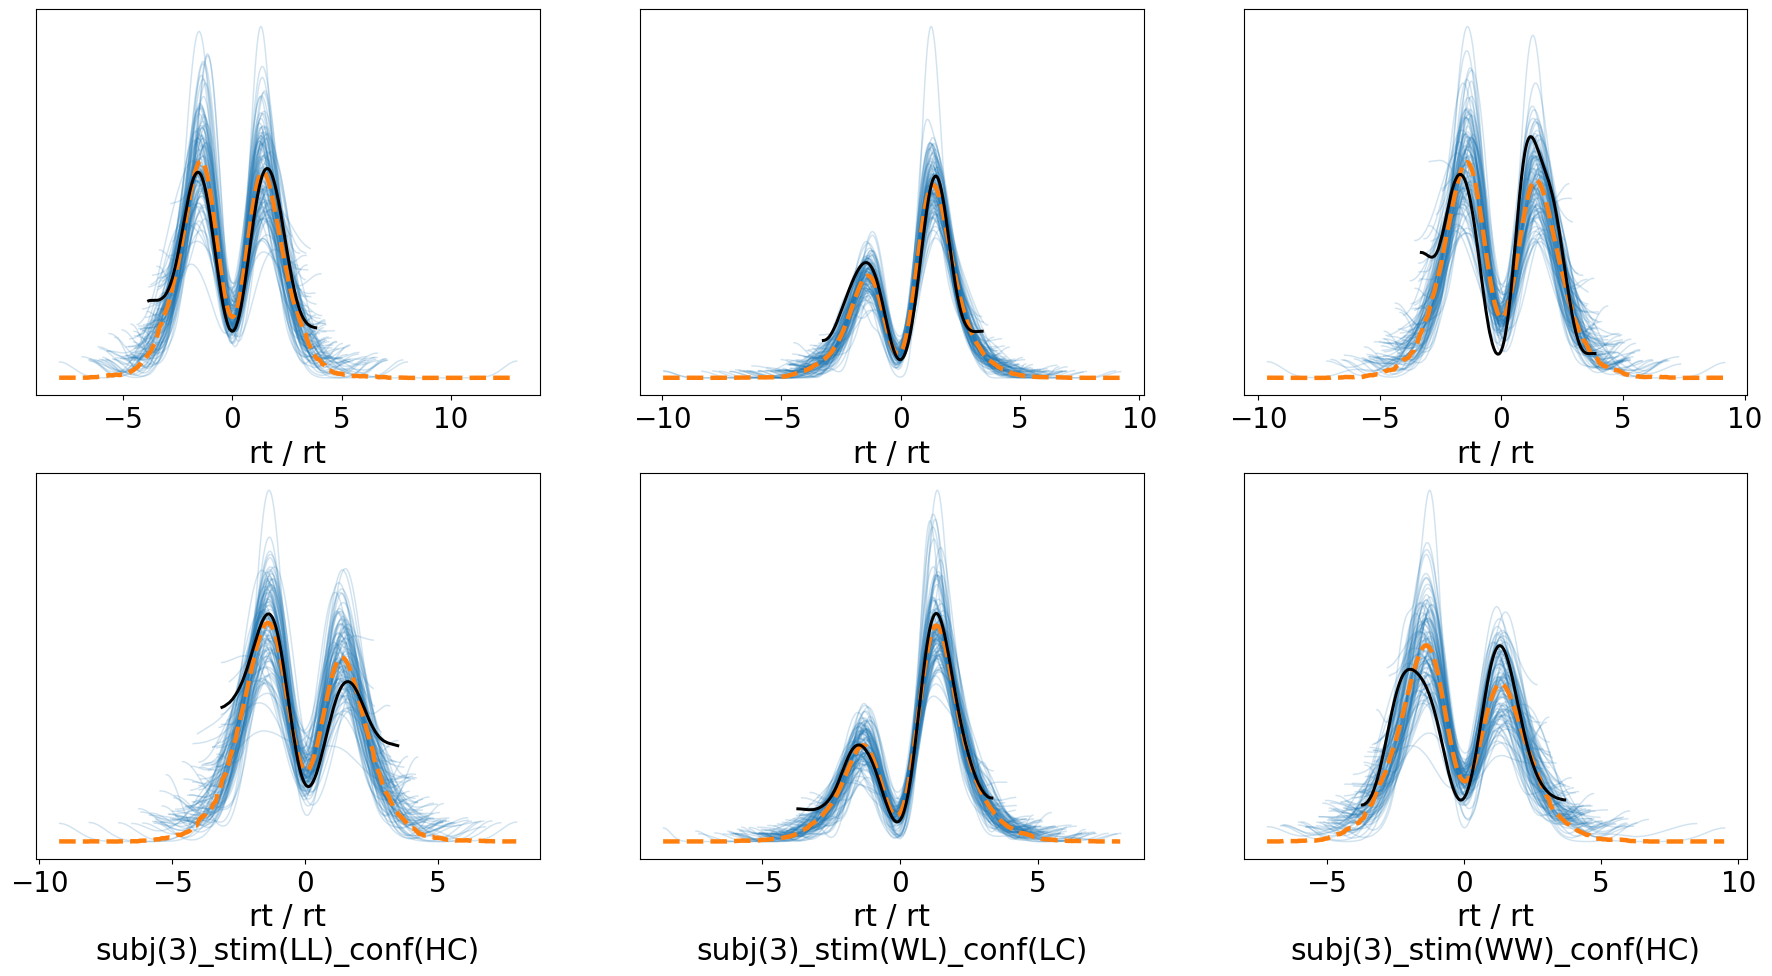

In [70]:
# examples

# # only consider all subjects
# plot_ppc_by_cond(
#     infdata,
#     num_pp_samples=100,
#     random_seed=2024,
#     legend=False,
#     textsize=20,
#     alpha=0.2
# )
# plt.show()

# # select few subjects
# subj_idx = [0, 3]
# plot_ppc_by_cond(infdata,
#                  subj_idx=subj_idx,
#                  num_pp_samples=100,
#                  random_seed=2024,
#                  legend=False,
#                  textsize=20,
#                  alpha=0.2)
# plt.show()

# # only condition group
# condition_vars = "conf"
# plot_ppc_by_cond(infdata,
#                  condition_vars=condition_vars,
#                  num_pp_samples=100,
#                  random_seed=2024,
#                  legend=False,
#                  textsize=20,
#                  alpha=0.2)
# plt.show()

# # two condition group
# condition_vars = ["conf", "stim"]
# plot_ppc_by_cond(infdata,
#                  condition_vars=condition_vars,
#                  num_pp_samples=100,
#                  random_seed=2024,
#                  legend=False,
#                  textsize=20,
#                  alpha=0.2)
# plt.show()

# # select condition level
# subj_idx = [0, 3]
# condition_vars = {"stim": ["LL", "WW"]}
# plot_ppc_by_cond(infdata,
#                  condition_vars=condition_vars,
#                  num_pp_samples=100,
#                  random_seed=2024,
#                  legend=False,
#                  textsize=20,
#                  alpha=0.2)
# plt.show()

# # select subjects and condition level
# condition_vars = {"stim": ["LL", "WW"]}
# subj_idx = [0, 3]
# plot_ppc_by_cond(infdata,
#                  subj_idx = subj_idx,
#                  condition_vars=condition_vars,
#                  num_pp_samples=100,
#                  random_seed=2024,
#                  legend=False,
#                  textsize=20,
#                  alpha=0.2)
# plt.show()

# more examples
condition_vars = ['stim','conf']
subj_idx = [0, 3]
plot_ppc_by_cond(m2_infdata,
                 subj_idx=subj_idx,
                 condition_vars=condition_vars,
                 num_pp_samples=100,
                 random_seed=2024,
                 legend=False,
                 textsize=20,
                 alpha=0.2)
plt.show()

## Statistical Inference

Here we onlyu examplified how to us ROPE + HDI method. 

- Assume that we are interested in the effect of conflit level on drift rate `v` and we used [-0.2, 0.2] as the ROPE. 
- Then we can used visualize the ROPE and HDI with `az.plot_posterior()`.

(-0.9, 0.3)

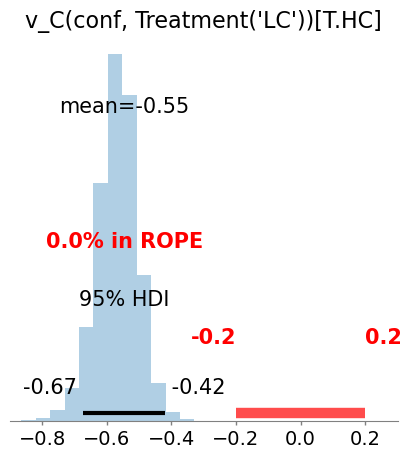

In [71]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
axes = az.plot_posterior(
    m2_infdata,
    var_names=("v_C(conf, Treatment('LC'))[T.HC]"),
    kind = 'hist',
    hdi_prob = 0.95,
    rope = [-0.2, 0.2], # assume this is our ROPE
    textsize=14, 
    rope_color = 'r',
    figsize = (5,5)
)
axes.set_xlim(-0.9,0.3)

In [ ]:
# render figure for manuscript
axes.figure.savefig("fig_posterior_inference_m2_drift_rate_on_conflict.pdf")

It is easy to find that the drift rate in HC is lower than it in LC. 

Then we plot the posteriors distribution of drift rates in both condition to reaffirm this results. 

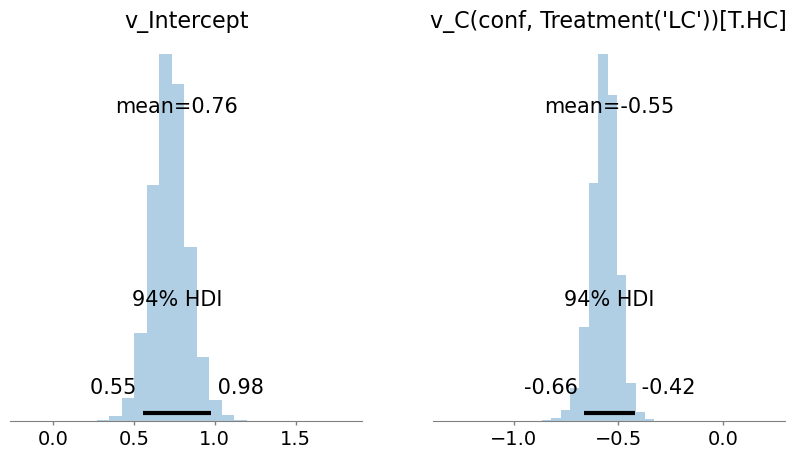

In [72]:
# plot posterior histgram by conditions, 
# v_Intercept represent v in LC 
# and v_C(conf, Treatment('LC'))[T.HC] represent v in HC. 
axes = az.plot_posterior(
    m2_infdata, 
    var_names=("^v(?!.*(subj|std))"), 
    filter_vars='regex', 
    kind='hist',
    figsize = (10,5)
)

In [73]:
m2_infdata.posterior["v_HC"] = (
    ("chain", "draw"),
    m2_infdata.posterior["v_Intercept"].values + \
    m2_infdata.posterior["v_C(conf, Treatment('LC'))[T.HC]"].values)
m2_infdata.posterior["v_LC"] = (
    ("chain", "draw"),
    m2_infdata.posterior["v_Intercept"].values)

Compare posterior using plot_forest. See [`az.plot_forest`](https://python.arviz.org/en/latest/api/generated/arviz.plot_forest.html#arviz.plot_forest) for more.

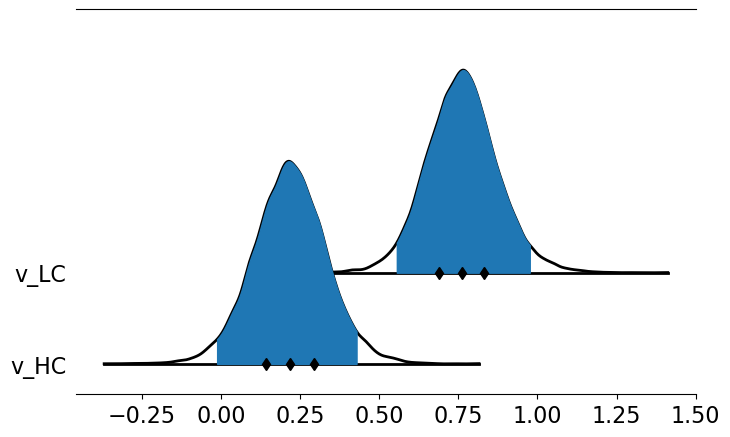

In [74]:
 # plot posterior forest distriution by conditions
axes = az.plot_forest(
    m2_infdata,
    kind='ridgeplot',
    var_names=("v_LC", "v_HC"), 
    linewidth=2,
    ridgeplot_overlap=3,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[.25, .5, .75],
    combined=True,
    figsize=(8, 5)
 )

Similarly, violin plot can also be used:

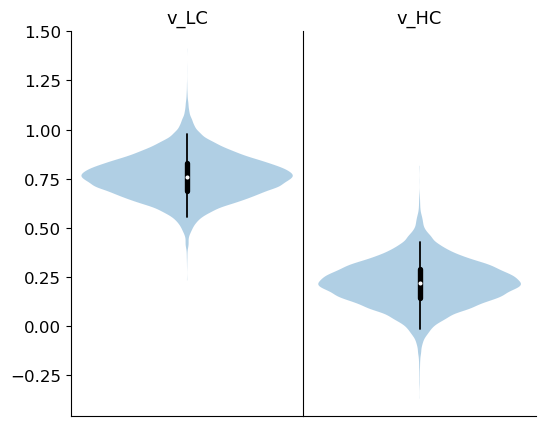

In [75]:
import seaborn as sns
# plot posterior violin plot by conditions
axes = az.plot_violin(
    m2_infdata, 
    var_names=("v_LC", "v_HC"), 
    figsize=(6, 5),
    textsize=12
)

sns.despine()

In [ ]:
# render figure for manuscript
axes.ravel()[0].figure.savefig("fig_posterior_inference_m2_drift_rate_on_conflict_violin.pdf")